In [1]:
import os
from joblib import dump, load
import pickle
import sys
sys.path.insert(0, os.path.join(os.getcwd(),os.pardir))
from collections import Counter
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from nltk.stem.lancaster import LancasterStemmer
from mpl_toolkits.mplot3d import Axes3D

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC

In [2]:
svc = load("log_reg.joblib")#load("best_linearSVC.joblib")

In [3]:
FILES  = ["train","val","test"]
FOLDER = os.path.join(os.getcwd(),os.pardir,"recipe_1m_analysis","data")
file = FILES[0]

In [4]:
enc = load("scikit_vocab_cuisine.joblib")

In [5]:
with open(os.path.join(FOLDER,"recipe1m_"+file+".pkl"),"rb") as f:
    data = pickle.load(f)

In [6]:
ingr_input = [";".join([ingr.name for ingr in recipe["ingredients"]]) for recipe in data.values() ]

In [7]:
vocab = load("scikit_vocab.joblib")

In [8]:
cv = CountVectorizer(vocabulary=vocab)
X = cv.fit_transform(ingr_input)

In [9]:
prediction = svc.predict(X)
len(prediction)

268012

In [10]:
str_pred =enc.inverse_transform(prediction)

In [11]:
counter_svc=Counter(str_pred)

In [12]:
len(str_pred)

268012

In [13]:
for i,v in enumerate(data.values()):
    v["cuisine"]=str_pred[i]

In [14]:
with open(os.path.join(FOLDER,"recipe1m_"+file+"_cuisine_log_reg.pkl"), "wb") as f:
    pickle.dump(data, f)

## Load NN classified file

In [15]:
with open(os.path.join(FOLDER,"recipe1m_"+file+"_cuisine_nn.pkl"),"rb") as f:
    data_nn = pickle.load(f)

In [16]:
with open(os.path.join(os.getcwd(),"results","vocab_cuisine.pkl"), "rb") as f:
    vocab_cuisine = pickle.load(f)

In [17]:
for el in counter_svc.keys():
    vocab_cuisine.add_word(el)

In [18]:
counter_nn=Counter([recp["cuisine"] for recp in data_nn.values()])

In [46]:
coherence_matrix = np.zeros((len(vocab_cuisine.word2idx),len(vocab_cuisine.word2idx)),dtype=np.int)
np.set_printoptions(suppress=True)
for idx,recp in data_nn.items():
    coherence_matrix[vocab_cuisine.word2idx[recp["cuisine"]]][vocab_cuisine.word2idx[data[idx]["cuisine"]]]+=1
or_northUS = coherence_matrix[0][0]
coherence_matrix[0][0]=16000
or_northUS

179304

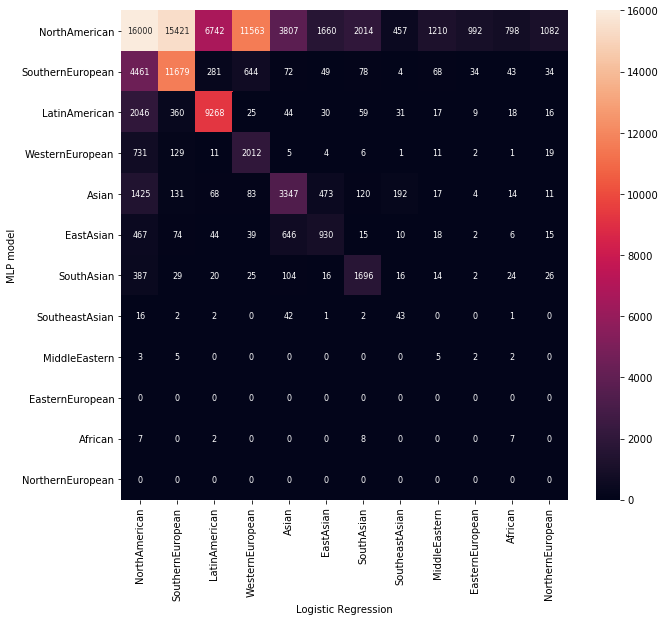

In [45]:
df_cm = pd.DataFrame(coherence_matrix, index = vocab_cuisine.word2idx.keys(),
                  columns = vocab_cuisine.word2idx.keys())
plt.figure(figsize=(10,9))
#sn.set(font_scale=0.8) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8}, fmt='g') # font size
plt.xlabel("Logistic Regression")
plt.ylabel("MLP model")
plt.show()

In [47]:
or_northUS/len(data)

0.6690148202319299

In [43]:
np.trace(coherence_matrix)-coherence_matrix[0][0]+or_northUS

208291

In [44]:
(np.trace(coherence_matrix)-coherence_matrix[0][0]+or_northUS)/len(data)

0.7771704252048416

### 95% confidence

In [48]:
#95% pred
threshold=0.95
y_pred_prob = svc.predict_proba(X)
max_prob = y_pred_prob.max(axis=1)
y_pred = y_pred_prob.argmax(axis=1)

to_del = np.argwhere(max_prob < threshold).T[0]

partial_y_pred = np.delete(y_pred,to_del)
partial_y_pred

array([6, 6, 6, ..., 6, 6, 6], dtype=int64)

In [49]:
len(partial_y_pred)

6449

In [50]:
log_reg95count = Counter(partial_y_pred)

In [56]:
log_reg95count

Counter({6: 5667, 4: 432, 10: 334, 8: 12, 1: 3, 11: 1})

In [51]:
with open(os.path.join(FOLDER,"recipe1m_"+file+"_cuisine_nn0.95.pkl"),"rb") as f:
    data_nn95 = pickle.load(f)

In [52]:
predicted = [recp["cuisine"] for recp in data_nn95.values() if "cuisine" in recp]

In [53]:
len(predicted)

79576

In [54]:
nn95count = Counter(predicted)

In [57]:
nn95count

Counter({'NorthAmerican': 77190,
         'SouthernEuropean': 1804,
         'LatinAmerican': 419,
         'Asian': 21,
         'WesternEuropean': 61,
         'SouthAsian': 41,
         'EastAsian': 40})

In [59]:
len(data)

268012

In [ ]:
coherence_matrix = np.zeros((len(nn95count),len(log_reg95count)),dtype=np.int)
np.set_printoptions(suppress=True)
for idx,recp in data_nn95.items():
    coherence_matrix[vocab_cuisine.word2idx[recp["cuisine"]]][vocab_cuisine.word2idx[data[idx]["cuisine"]]]+=1
print(coherence_matrix[0][0])
coherence_matrix[0][0]=14000

In [ ]:
df_cm = pd.DataFrame(coherence_matrix, index = counter_nn.keys(),
                  columns = counter_svc.keys())
plt.figure(figsize=(10,9))
#sn.set(font_scale=0.8) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8}, fmt='g') # font size
plt.xlabel("Linear SVC model")
plt.ylabel("MLP model")
plt.show()
